In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.text import Text
import numpy as np
from scipy.special import gamma

from numpy.random import default_rng

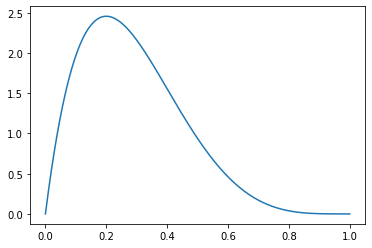

<Figure size 432x288 with 0 Axes>

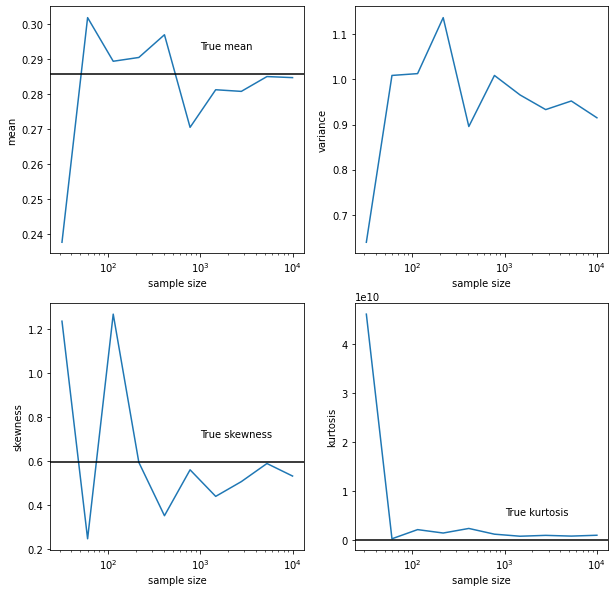

In [53]:
# https://en.wikipedia.org/wiki/Beta_distribution
class BetaDistribuiton:
    def __init__(self, a, b) -> None:
        self.a = a
        self.b = b
    
    def beta(self):
        return gamma(self.a)*gamma(self.b) / gamma(self.a + self.b)
    
    def pdf(self, in_x):
        return np.power(in_x, self.a - 1)*np.power(1 - in_x, self.b - 1)/self.beta()

    def mean(self):
        return (self.a / (self.a + self.b))

    def variance(self):
        return (self.a * self.b)/np.power(self.a + self.b, 2)*(self.a + self.b + 1)

    def skewness(self):
        return (2*(self.b - self.a)*np.sqrt(self.a + self.b + 1)) / ((self.a + self.b + 2)*np.sqrt(self.a * self.b))

    def kurtosis(self):
        return 6*((self.a - self.b)*(self.a - self.b)*(self.a + self.b + 1) - self.a*self.b*(self.a + self.b + 2)) / (self.a * self.b * (self.a + self.b + 2)*(self.a + self.b + 3))

    def get_moment(self, n):
        if n == 1:
            return self.mean()
        elif n == 2:
            return self.variance()
        elif n == 3:
            return self.skewness()
        elif n == 4:
            return self.kurtosis()
        else:
            raise NotImplementedError("No other known moments!")
    
    def E(self, exp_val, in_sample):
        return np.mean(exp_val * self.pdf(in_sample))

exp_gen_fn = {
    1: lambda x: x,
    2: lambda x: np.power((x - using_dist.mean())/np.var(x)**1/2, 2),
    3: lambda x: np.power((x - using_dist.mean())/np.var(x)**1/2, 3),
    4: lambda x: np.power((x - using_dist.mean())/np.var(x)**3/2, 4),
}

ini_seed = 420
def calc_central_moment(in_dist, sample_size, k):
    rand_gen = default_rng(int(ini_seed * (np.log2(sample_size) + sample_size) * k))
    sample = rand_gen.uniform(0, 1, int(sample_size))
    
    in_exp = exp_gen_fn[k](sample)
    moment_k = in_dist.E(in_exp, sample)
    return moment_k


using_dist = BetaDistribuiton(2., 5.)
xs = np.linspace(0, 1, 1000)
ys = using_dist.pdf(xs)
plt.plot(xs, ys)
plt.show()
plt.clf()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
moment_name = ["mean", "variance", "skewness", "kurtosis"]
for m_i, m_k in enumerate(range(1, 5)):
    true_moment = using_dist.get_moment(m_k)
    x_s = list(np.logspace(1.5, 4, 10))
    y_s = [calc_central_moment(using_dist, s_size, m_k) for s_size in x_s]
    
    ax_col = m_i % 2
    ax_row = m_i // 2
    
    cur_ax = axs[ax_row][ax_col]
    cur_ax.plot(x_s, y_s)
    cur_ax.set_xscale("log")
    cur_ax.set_xlabel("sample size")
    cur_ax.set_ylabel(moment_name[m_i])
    
    y_min, y_max =cur_ax.get_ylim()
    y_off = abs(y_max - y_min) * 0.1
    true_line = Line2D([0, 10e4], [true_moment, true_moment], color="black")
    true_text = Text(10e2, true_moment + y_off, "True " + moment_name[m_i])
    cur_ax.add_artist(true_line)
    cur_ax.add_artist(true_text)
    